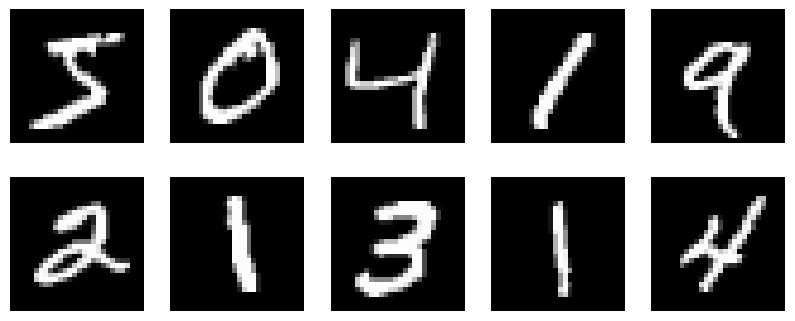

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from src.ppca import ppca_closed_form, mppca


# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Reshape the data for visualization (28x28 images)
X_images = X.values.reshape(-1, 28, 28)

# Display the first 10 images from the dataset
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [101]:
import torch as th
from tqdm.auto import trange
device = "cuda" if th.cuda.is_available() else "cpu"
from src.ppca import ppca_closed_form, mppca

In [111]:
import torch as th
import numpy as np
from src.ppca import ppca_closed_form, device
import pytest

def test_ppca_synthetic():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data
    n_samples = 1000  # number of samples
    d = 10           # observed dimensions
    q = 3            # latent dimensions
    
    # Create true parameters
    W_true = th.randn(d, q).to(device)  # true weight matrix
    z = th.randn(n_samples, q).to(device)  # latent variables
    noise = 0.1 * th.randn(n_samples, d).to(device)  # observation noise
    
    # Generate observations
    X = z @ W_true.T + noise
    
    # Run PPCA
    W_estimated = ppca_closed_form(X, q)
    
    # Since PPCA is invariant to rotations, we need to compare the subspaces
    # rather than the exact matrices
    
    # Compare subspaces using principal angles
    U1 = th.linalg.qr(W_true)[0]
    U2 = th.linalg.qr(W_estimated)[0]
    
    # Compute cosines of principal angles
    cosines = th.abs(U1.T @ U2)
    min_cosine = cosines.min()
    
    # Check if the subspaces are similar (allowing for some numerical error)
    assert min_cosine > 0.9, f"Subspaces are too different: minimum cosine is {min_cosine}"
    
    # Check output dimensions
    assert W_estimated.shape == (d, q), f"Wrong output shape: {W_estimated.shape}"
test_ppca_synthetic()

AssertionError: Subspaces are too different: minimum cosine is 0.10793108493089676

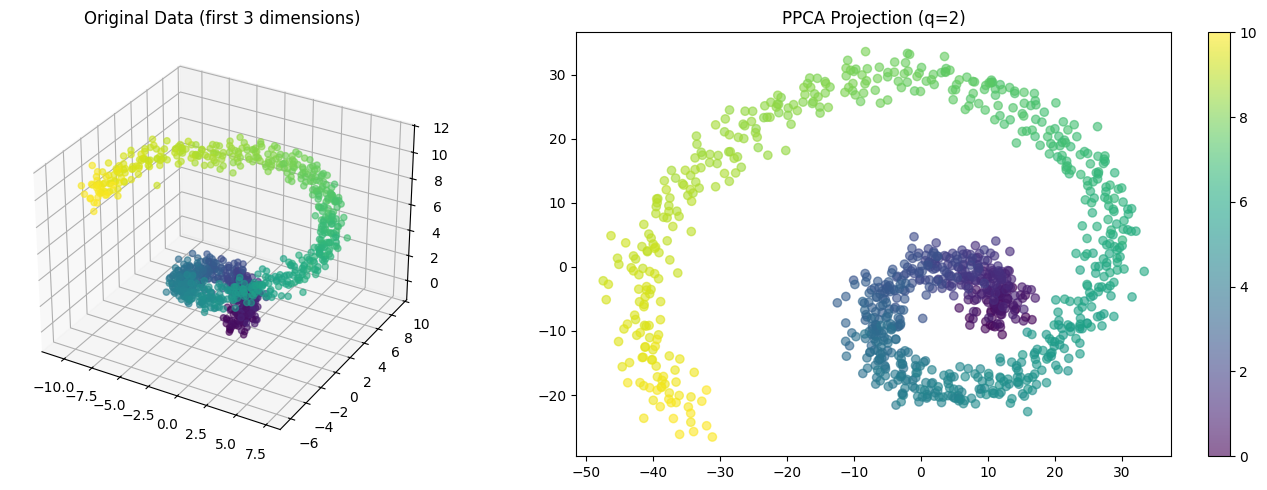

In [116]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form

def visual_test_ppca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions to make it more interesting
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data
    X_centered = X - X.mean(dim=0)
    X_projected = X_centered @ W
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(121, projection='3d')
    ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax1.set_title('Original Data (first 3 dimensions)')
    
    # PPCA projection
    ax2 = plt.subplot(122)
    scatter = ax2.scatter(X_projected[:, 0].cpu().numpy(), X_projected[:, 1].cpu().numpy(),
                         c=t.cpu().numpy(), cmap='viridis', alpha=0.6)
    ax2.set_title('PPCA Projection (q=2)')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

visual_test_ppca()

  0%|          | 0/100 [00:00<?, ?it/s]

sigma_ml: tensor([0.0089, 0.0177, 0.0179], device='cuda:0')
sigma_ml: tensor([0.0002, 0.0071, 0.0049], device='cuda:0')
sigma_ml: tensor([1.2004e-10, 4.1842e-03, 1.5244e-03], device='cuda:0')
sigma_ml: tensor([1.6685e-10, 2.8216e-03, 5.4330e-04], device='cuda:0')
sigma_ml: tensor([1.6452e-11, 2.0911e-03, 1.5289e-05], device='cuda:0')
sigma_ml: tensor([2.0693e-11, 1.6664e-03, 3.6873e-10], device='cuda:0')
sigma_ml: tensor([1.8535e-10, 1.3810e-03, 4.9071e-10], device='cuda:0')
sigma_ml: tensor([1.9179e-10, 1.1491e-03, 4.9582e-10], device='cuda:0')
sigma_ml: tensor([1.5804e-10, 9.3071e-04, 3.8132e-10], device='cuda:0')
sigma_ml: tensor([3.6143e-10, 7.1809e-04, 3.8131e-10], device='cuda:0')
sigma_ml: tensor([3.7511e-10, 5.1325e-04, 3.1500e-10], device='cuda:0')
sigma_ml: tensor([1.7754e-10, 3.0507e-04, 1.6780e-10], device='cuda:0')
sigma_ml: tensor([3.9858e-11, 1.2175e-04, 3.8040e-10], device='cuda:0')
sigma_ml: tensor([2.4045e-10, 2.2439e-05, 3.0974e-10], device='cuda:0')
sigma_ml: tensor

C:\Users\Travail\AppData\Local\Temp\ipykernel_18040\3091191389.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


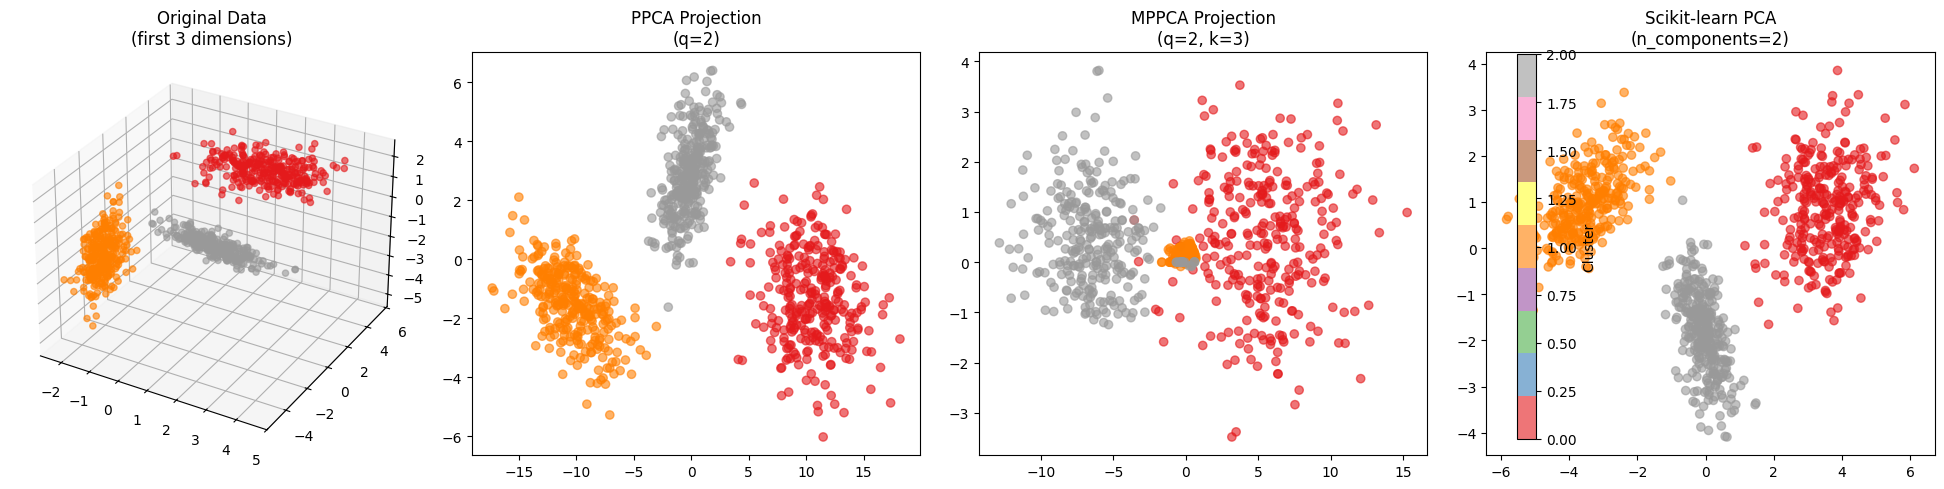

PCA explained variance ratio: [0.73810995 0.2054111 ]


In [3]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form, mppca
from sklearn.decomposition import PCA
device = "cuda" if th.cuda.is_available() else "cpu"
def test_mppca_visual():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with multiple clusters
    n_samples_per_cluster = 300
    n_clusters = 3
    n_samples = n_samples_per_cluster * n_clusters
    
    # Create clusters in 3D with different orientations
    clusters = []
    colors = []
    
    # Cluster 1: Horizontal plane with some noise
    z1 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    xy1 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0]).to(device)
    clusters.append(cluster1)
    colors.extend([0] * n_samples_per_cluster)
    
    # Cluster 2: Vertical plane with some noise
    x2 = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    yz2 = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0]).to(device)
    clusters.append(cluster2)
    colors.extend([1] * n_samples_per_cluster)
    
    # Cluster 3: Diagonal plane with some noise
    points = th.randn(n_samples_per_cluster, 2).to(device) * 1.0
    noise = th.randn(n_samples_per_cluster, 1).to(device) * 0.1
    rotation = th.tensor([[1.0, -1.0, 1.0], 
                         [1.0, 1.0, -1.0], 
                         [-1.0, 1.0, 1.0]]).to(device) / np.sqrt(3)
    cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0]).to(device)
    clusters.append(cluster3)
    colors.extend([2] * n_samples_per_cluster)
    
    # Combine all clusters
    X = th.cat(clusters, dim=0)
    colors = th.tensor(colors).to(device)
    
    # Add two extra noisy dimensions
    X = th.cat([X, 0.1 * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA, MPPCA and PCA
    W_ppca = ppca_closed_form(X, q=2)
    W_mppca, mu_mppca, sigma_mppca = mppca(X, q=2, k=3)
    pca = PCA(n_components=2)
    
    # Project the data
    X_centered_ppca = X - X.mean(dim=0)
    X_ppca = X_centered_ppca @ W_ppca
    
    # For MPPCA, project using the closest component
    distances = []
    for i in range(3):
        diff = X - mu_mppca[i].unsqueeze(0)
        distances.append(th.sum(diff * diff, dim=1))
    closest_component = th.stack(distances).argmin(dim=0)
    
    X_mppca = th.zeros_like(X_ppca)
    for i in range(3):
        mask = (closest_component == i)
        X_centered_mppca = X[mask] - mu_mppca[i].unsqueeze(0)
        X_mppca[mask] = X_centered_mppca @ W_mppca[i]
    
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    fig = plt.figure(figsize=(20, 5))
    
    # Original 3D data
    ax1 = fig.add_subplot(141, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax1.set_title('Original Data\n(first 3 dimensions)')
    
    # PPCA projection
    ax2 = fig.add_subplot(142)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax2.set_title('PPCA Projection\n(q=2)')
    
    # MPPCA projection
    ax3 = fig.add_subplot(143)
    scatter3 = ax3.scatter(X_mppca[:, 0].cpu().numpy(), X_mppca[:, 1].cpu().numpy(),
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax3.set_title('MPPCA Projection\n(q=2, k=3)')
    
    # PCA projection
    ax4 = fig.add_subplot(144)
    scatter4 = ax4.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=colors.cpu().numpy(), cmap='Set1', alpha=0.6)
    ax4.set_title('Scikit-learn PCA\n(n_components=2)')
    
    # Add a single colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3, ax4], label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

if __name__ == "__main__":
    test_mppca_visual()

In [19]:
sigma_mppca

tensor([3.8069e-08, 3.1901e-08, 5.1978e-10], device='cuda:0')

  0%|          | 0/100 [00:00<?, ?it/s]

sigma_ml: tensor([0.1175, 0.0444, 0.0853], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0133, 0.0130, 0.0317], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0096, 0.0141], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0090, 0.0102], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0088, 0.0098], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0087, 0.0098], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0086, 0.0098], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0086, 0.0098], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0086, 0.0098], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0109, 0.0086, 0.0098], device='cuda:0', dtype=torch.float64)
Finished in 9 iterations with update size 2.732760721654493e-05


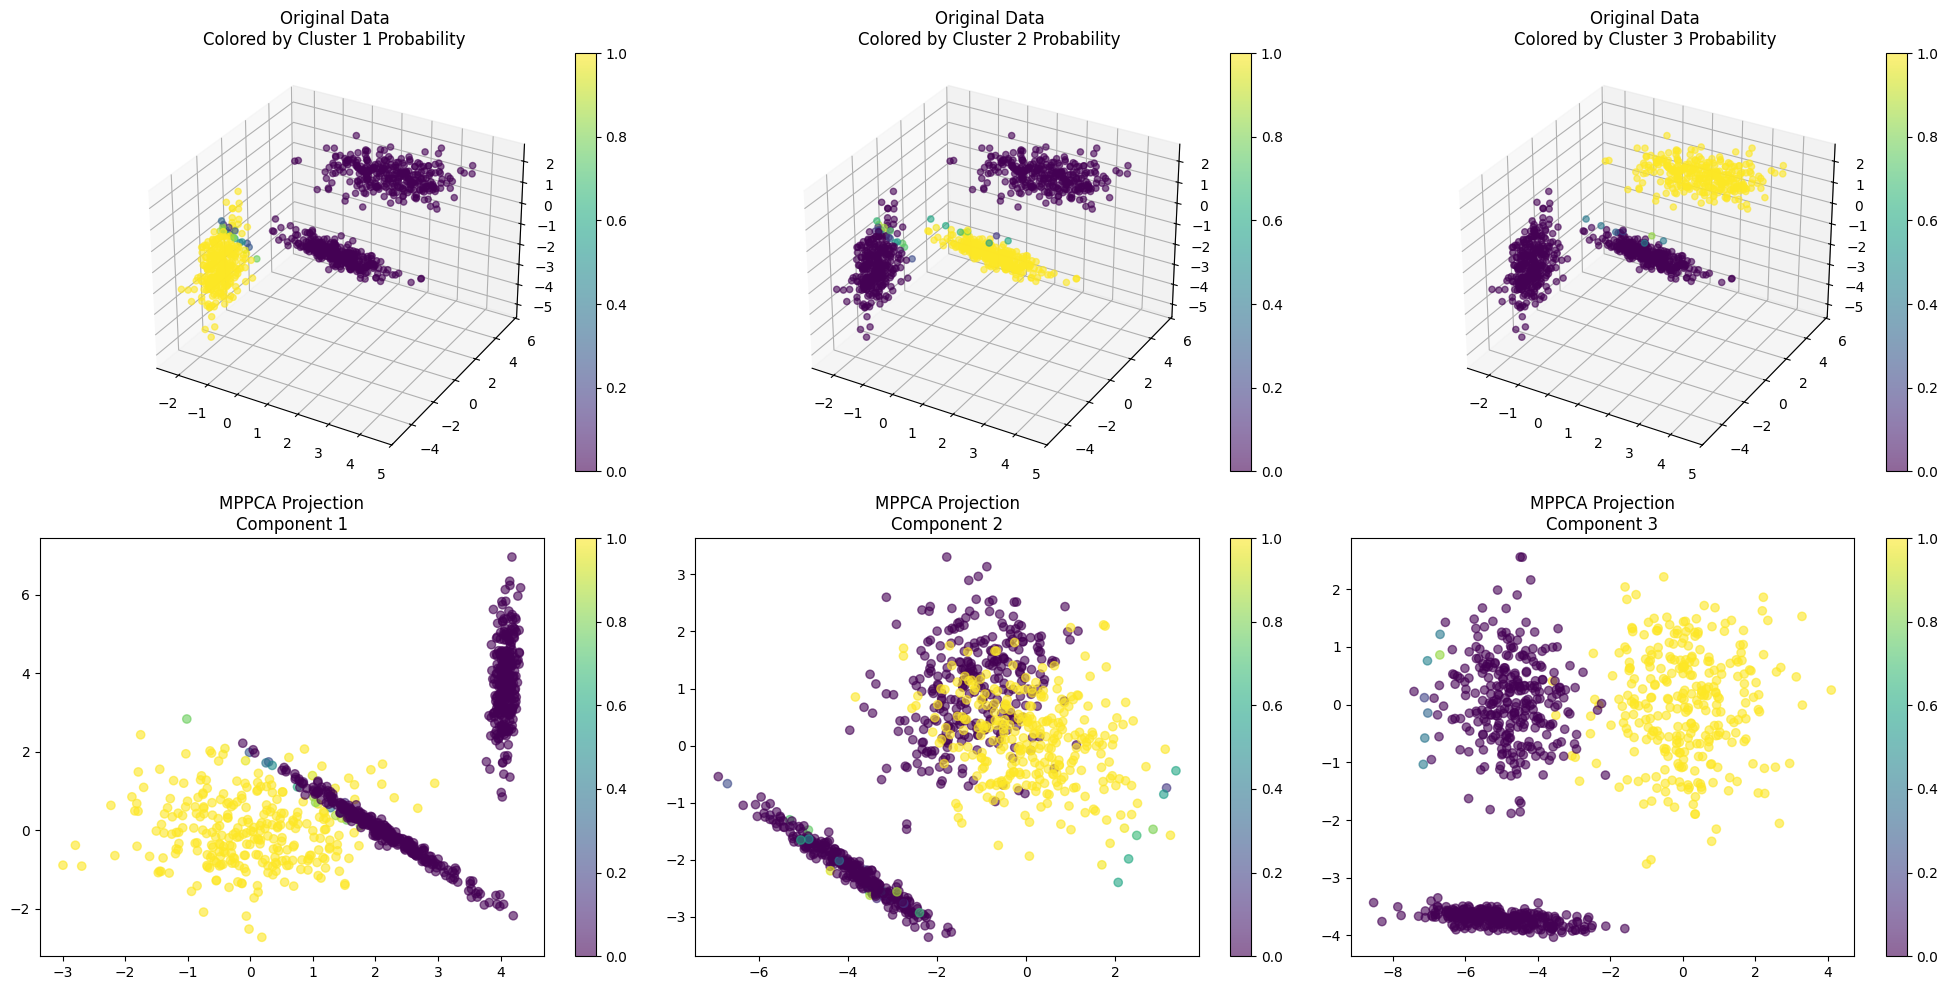

Mixing coefficients: [0.32280537 0.34044954 0.33674509]


In [1]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)

# Generate synthetic data with multiple clusters
n_samples_per_cluster = 300
n_clusters = 3
n_samples = n_samples_per_cluster * n_clusters

# Create clusters in 3D with different orientations
clusters = []

# Cluster 1: Horizontal plane with some noise
z1 = th.randn(n_samples_per_cluster, 1) * 0.1
xy1 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster1 = th.cat([xy1, z1], dim=1) + th.tensor([2.0, 2.0, 2.0])
clusters.append(cluster1)

# Cluster 2: Vertical plane with some noise
x2 = th.randn(n_samples_per_cluster, 1) * 0.1
yz2 = th.randn(n_samples_per_cluster, 2) * 1.0
cluster2 = th.cat([x2, yz2], dim=1) + th.tensor([-2.0, -2.0, -2.0])
clusters.append(cluster2)

# Cluster 3: Diagonal plane with some noise
points = th.randn(n_samples_per_cluster, 2) * 1.0
noise = th.randn(n_samples_per_cluster, 1) * 0.1
rotation = th.tensor([[1.0, -1.0, 1.0], 
                        [1.0, 1.0, -1.0], 
                        [-1.0, 1.0, 1.0]]) / np.sqrt(3)
cluster3 = (th.cat([points, noise], dim=1) @ rotation) + th.tensor([2.0, -2.0, 0.0])
clusters.append(cluster3)

# Combine all clusters
X = th.cat(clusters, dim=0).to(device)

# Add two extra noisy dimensions
X = th.cat([X, 0.1 * th.randn(n_samples, 2, device=device)], dim=1)

# Run MPPCA
W_mppca, mu_mppca, sigma_mppca = mppca(X, q=2, k=3)

# Calculate responsibilities using the same code as in mppca implementation
n, d = X.shape
k = W_mppca.shape[0]

M = W_mppca.transpose(1, 2) @ W_mppca + sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(2, device=device).unsqueeze(0)
M_inv = M.inverse()
Z = th.einsum(
    "kqd, knd -> knq",
    M_inv @ W_mppca.transpose(1, 2),
    (X.unsqueeze(0) - mu_mppca.unsqueeze(1)),
)

mu_normals = th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1)
sigma_normals = sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(d, device=device)

prob = (
    -0.5
    * th.einsum(
        "knD, knD -> kn",
        th.einsum(
            "knd, kdD -> knD",
            (X.unsqueeze(0) - mu_normals),
            sigma_normals.inverse(),
        ),
        (X.unsqueeze(0) - mu_normals),
    )
).exp() / ((2 * np.pi * sigma_mppca) ** (d / 2)).unsqueeze(1)

pi = th.ones(k, device=device) / k  # equal mixing coefficients
responsibilities = prob * pi.unsqueeze(1)
responsibilities /= responsibilities.sum(dim=0, keepdim=True)

# Project data for each component
X_mppca = th.zeros(k, n, 2, device=device)
for j in range(k):
    X_centered = X - mu_mppca[j].unsqueeze(0)
    X_mppca[j] = X_centered @ W_mppca[j]

# Plotting
fig = plt.figure(figsize=(20, 10))

# Original 3D data with probabilities for each cluster
for j in range(k):
    # Original data
    ax1 = fig.add_subplot(2, k, j+1, projection='3d')
    scatter1 = ax1.scatter(X.cpu()[:, 0], X.cpu()[:, 1], X.cpu()[:, 2], 
                            c=responsibilities[j].cpu(), 
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax1.set_title(f'Original Data\nColored by Cluster {j+1} Probability')
    plt.colorbar(scatter1, ax=ax1)
    
    # MPPCA projection
    ax2 = fig.add_subplot(2, k, j+k+1)
    scatter2 = ax2.scatter(X_mppca[j].cpu()[:, 0], X_mppca[j].cpu()[:, 1],
                            c=responsibilities[j].cpu(),
                            cmap='viridis', alpha=0.6,
                            vmin=0, vmax=1)
    ax2.set_title(f'MPPCA Projection\nComponent {j+1}')
    plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

# Print the mixing coefficients (proportion of points assigned to each cluster)
print("Mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())

In [7]:
%load_ext autoreload
%autoreload 2
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import mppca
from ref import initialization_kmeans, mppca_gem

device = "cuda" if th.cuda.is_available() else "cpu"

# Set random seed for reproducibility
th.manual_seed(42)
np.random.seed(42)
q = 1
# Generate cross-shaped data
n_samples_per_arm = 200
noise = 0.1

# Horizontal arm
x1 = np.random.uniform(-2, 2, n_samples_per_arm)
y1 = np.random.normal(0, noise, n_samples_per_arm)

# Vertical arm
x2 = np.random.normal(0, noise, n_samples_per_arm)
y2 = np.random.uniform(-2, 2, n_samples_per_arm)

# Combine the arms
X_np = np.vstack([
    np.column_stack([x1, y1]),
    np.column_stack([x2, y2])
])

# Add a third noisy dimension
X_np = np.column_stack([X_np, np.random.normal(0, noise, X_np.shape[0])])

# Convert to torch tensor
X = th.tensor(X_np, dtype=th.float32).to(device)

# Run our MPPCA implementation
W_mppca, mu_mppca, sigma_mppca = mppca(X, q=q, k=2)

# Calculate responsibilities for our implementation
n, d = X.shape
k = W_mppca.shape[0]

M = W_mppca.transpose(1, 2) @ W_mppca + sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(2, device=device).unsqueeze(0)
M_inv = M.inverse()
Z = th.einsum(
    "kqd, knd -> knq",
    M_inv @ W_mppca.transpose(1, 2),
    (X.unsqueeze(0) - mu_mppca.unsqueeze(1)),
)

mu_normals = th.einsum("kdq, knq -> knd", W_mppca, Z) + mu_mppca.unsqueeze(1)
sigma_normals = sigma_mppca.unsqueeze(-1).unsqueeze(-1) * th.eye(d, device=device)

# Calculate log responsibilities for numerical stability
log_resp = (
    th.log(th.ones(k, device=device) / k).unsqueeze(1)  # [k, 1]
    - 0.5 * d * th.log(2 * np.pi * sigma_mppca).unsqueeze(1)  # [k, 1]
    - 0.5 * th.einsum(
        "knD,knD->kn",
        th.einsum(
            "knd,kdD->knD",
            (X.unsqueeze(0) - mu_normals),
            sigma_normals.inverse(),
        ),
        (X.unsqueeze(0) - mu_normals),
    )
)

# Numerical stability: subtract max and exp
log_resp_max = log_resp.max(dim=0, keepdim=True)[0]
responsibilities = (log_resp - log_resp_max).exp()
responsibilities /= responsibilities.sum(dim=0, keepdim=True)

# Run reference implementation
pi_ref, mu_ref, W_ref, sigma2_ref, clusters_ref = initialization_kmeans(X_np, 2, q)
pi_ref, mu_ref, W_ref, sigma2_ref, R_ref, L_ref, sigma2hist_ref = mppca_gem(X_np, pi_ref, mu_ref, W_ref, sigma2_ref, 100)

# Plotting
fig = plt.figure(figsize=(15, 10))

# Original data
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c='blue', alpha=0.6)
ax1.set_title('Original Data')

# Our MPPCA implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+2)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=responsibilities[j].cpu(),
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Our MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

# Reference implementation results
for j in range(k):
    ax = fig.add_subplot(2, 3, j+5)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=R_ref[:, j],
                        cmap='viridis', alpha=0.6, vmin=0, vmax=1)
    ax.set_title(f'Reference MPPCA - Component {j+1}')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# Print comparison of results
print("Our MPPCA mixing coefficients:", responsibilities.mean(dim=1).cpu().numpy())
print("Reference MPPCA mixing coefficients:", pi_ref)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/100 [00:00<?, ?it/s]

sigma_ml: tensor([0.2915, 0.3613], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.1654, 0.0631], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0257, 0.0131], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0100, 0.0099], device='cuda:0', dtype=torch.float64)
sigma_ml: tensor([0.0090, 0.0099], device='cuda:0', dtype=torch.float64)
Finished in 4 iterations with update size 1.5918804446599536e-05


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 2] but got: [2, 3].

C:\Users\Travail\AppData\Local\Temp\ipykernel_22648\467100542.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


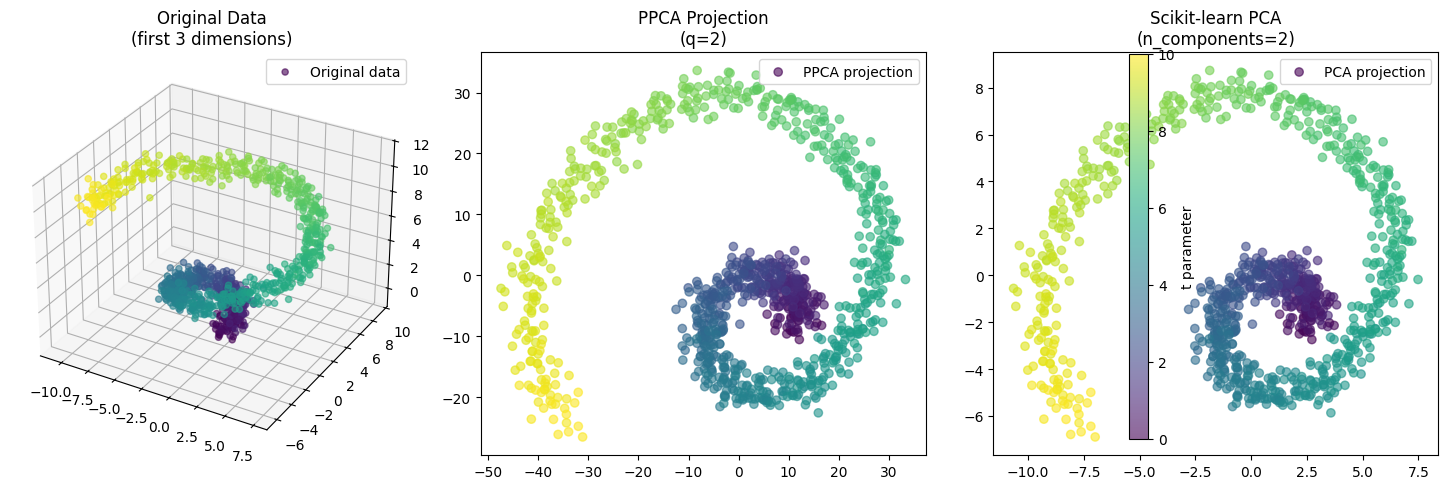

PCA explained variance ratio: [0.47779918 0.357017  ]


In [118]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from src.ppca import ppca_closed_form
from sklearn.decomposition import PCA

def compare_ppca_pca():
    # Set random seed for reproducibility
    th.manual_seed(42)
    np.random.seed(42)
    
    # Generate synthetic data with a clear structure
    n_samples = 1000
    
    # Create a 3D spiral
    t = th.linspace(0, 10, n_samples).to(device)
    x = t * th.cos(t).to(device)
    y = t * th.sin(t).to(device)
    z = t.to(device)
    
    # Add some noise
    noise_level = 0.5
    X = th.stack([x, y, z], dim=1) + noise_level * th.randn(n_samples, 3).to(device)
    
    # Add some extra noisy dimensions
    X = th.cat([X, noise_level * th.randn(n_samples, 2).to(device)], dim=1)
    
    # Run PPCA with q=2
    W = ppca_closed_form(X, q=2)
    
    # Project the data using PPCA
    X_centered = X - X.mean(dim=0)
    X_ppca = X_centered @ W
    
    # Run sklearn PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.cpu().numpy())
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Original 3D data
    ax1 = plt.subplot(131, projection='3d')
    scatter1 = ax1.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), X[:, 2].cpu().numpy(), 
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='Original data')
    ax1.set_title('Original Data\n(first 3 dimensions)')
    ax1.legend()
    
    # PPCA projection
    ax2 = plt.subplot(132)
    scatter2 = ax2.scatter(X_ppca[:, 0].cpu().numpy(), X_ppca[:, 1].cpu().numpy(),
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PPCA projection')
    ax2.set_title('PPCA Projection\n(q=2)')
    ax2.legend()
    
    # PCA projection
    ax3 = plt.subplot(133)
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=t.cpu().numpy(), cmap='viridis', alpha=0.6,
                          label='PCA projection')
    ax3.set_title('Scikit-learn PCA\n(n_components=2)')
    ax3.legend()
    
    # Add colorbar
    plt.colorbar(scatter1, ax=[ax1, ax2, ax3], label='t parameter')
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratio for PCA
    print("PCA explained variance ratio:", pca.explained_variance_ratio_)

compare_ppca_pca()

## Test ppca

IndexError: too many indices for tensor of dimension 1

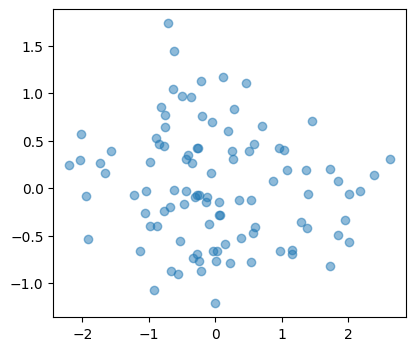

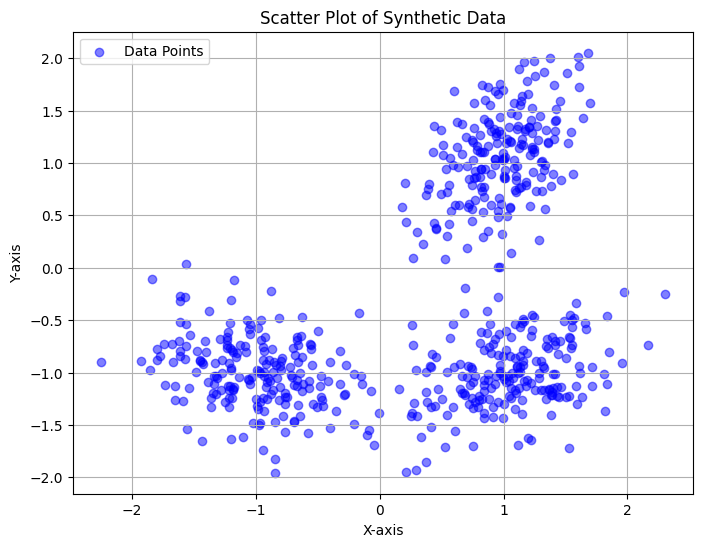

  0%|          | 0/100 [00:00<?, ?it/s]

sigma_ml: tensor([0.0821, 0.0489, 0.0660])
sigma_ml: tensor([0.0521, 0.0319, 0.0425])
sigma_ml: tensor([0.0329, 0.0241, 0.0324])
sigma_ml: tensor([0.0239, 0.0199, 0.0261])
sigma_ml: tensor([0.0190, 0.0171, 0.0216])
sigma_ml: tensor([0.0159, 0.0148, 0.0182])
sigma_ml: tensor([0.0140, 0.0131, 0.0156])
sigma_ml: tensor([0.0129, 0.0119, 0.0135])
sigma_ml: tensor([0.0122, 0.0111, 0.0118])
sigma_ml: tensor([0.0116, 0.0107, 0.0105])
sigma_ml: tensor([0.0110, 0.0105, 0.0095])
sigma_ml: tensor([0.0103, 0.0104, 0.0087])
sigma_ml: tensor([0.0093, 0.0102, 0.0080])
sigma_ml: tensor([0.0081, 0.0096, 0.0075])
sigma_ml: tensor([0.0071, 0.0087, 0.0070])
sigma_ml: tensor([0.0063, 0.0078, 0.0066])
sigma_ml: tensor([0.0056, 0.0071, 0.0063])
sigma_ml: tensor([0.0050, 0.0065, 0.0060])
sigma_ml: tensor([0.0045, 0.0060, 0.0057])
sigma_ml: tensor([0.0041, 0.0056, 0.0054])
sigma_ml: tensor([0.0037, 0.0053, 0.0051])
sigma_ml: tensor([0.0034, 0.0049, 0.0049])
sigma_ml: tensor([0.0031, 0.0046, 0.0047])
sigma_ml: t

_LinAlgError: linalg.inv: (Batch element 0): The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

In [104]:
# synthetic data experiment in 2d
import torch as th
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
th.manual_seed(42)

# Generate synthetic data from 2 Gaussians
n_samples = 200
n_components = 2

# First Gaussian centered at (1,1) with some covariance
mean1 = th.tensor([1.0, 1.0])
cov1 = th.tensor([[0.1, 0.05], [0.05, 0.2]])
samples1 = th.distributions.MultivariateNormal(mean1, cov1).sample((n_samples,))

# Second Gaussian centered at (-1,-1) with different covariance
mean2 = th.tensor([-1.0, -1.0]) 
cov2 = th.tensor([[0.2, -0.05], [-0.05, 0.1]])
samples2 = th.distributions.MultivariateNormal(mean2, cov2).sample((n_samples,))

# third gaussian
mean3 = th.tensor([1.0, -1.0])
cov3 = th.tensor([[0.2, 0.05], [0.05, 0.1]])
samples3 = th.distributions.MultivariateNormal(mean3, cov3).sample((n_samples,))

# Combine the samples
X = th.cat([samples1, samples2, samples3], dim=0)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, c='blue', label='Data Points')
plt.title('Scatter Plot of Synthetic Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()

# Initialize MPPCA parameters
k = 3  # number of components
d = 2  # data dimension
q = 1  # latent dimension
device = X.device

# Random initialization
W = th.randn(k, d, q).to(device)
mu = th.randn(k, d).to(device)
sigma = th.ones(k).to(device)
pi = th.ones(k).to(device) / k

# Fit MPPCA
W, mu, sigma = mppca(X, q, k, max_iter=100, epsilon=1e-6)

# Visualize results
plt.figure(figsize=(10, 5))

# Plot original data
plt.subplot(121)
plt.scatter(X[:n_samples,0], X[:n_samples,1], alpha=0.5, label='Cluster 1')
plt.scatter(X[n_samples:,0], X[n_samples:,1], alpha=0.5, label='Cluster 2')
plt.title('Original Data')
plt.legend()

# Plot principal components
plt.subplot(122)
for i in range(k):
    plt.scatter(mu[i,0], mu[i,1], c='red', marker='x', s=100)
    # Plot the principal direction
    direction = W[i,:,0]
    plt.arrow(mu[i,0], mu[i,1], direction[0], direction[1], 
             head_width=0.1, head_length=0.1, fc='k', ec='k')

plt.scatter(X[:,0], X[:,1], alpha=0.2, c='gray')
plt.title('MPPCA Components')
plt.axis('equal')
plt.show()


In [74]:
X = th.randn(3000, 2)
X = X - X.mean(dim=0)
einsu_res = th.einsum("Nd, ND -> NdD", X, X)
for_res = th.empty(3000, 2, 2)
for i in range(3000):
    for_res[i] = X[i].unsqueeze(1) @ X[i].unsqueeze(0)

assert th.allclose(einsu_res, for_res)

einsu_mean_res = th.einsum("Nd, ND -> dD", X, X)
assert th.allclose(einsu_mean_res, for_res.sum(dim=0))

vrai_cov = th.einsum("Nd, ND -> dD", X, X) / 2999
vrai_cov_th = X.T.cov()
assert th.allclose(vrai_cov, vrai_cov_th)
assert not th.allclose(vrai_cov, einsu_res.mean(dim=0))

In [75]:
einsu_res.mean(dim=0)

tensor([[ 1.0406, -0.0245],
        [-0.0245,  1.0129]])

In [76]:
vrai_cov_th

tensor([[ 1.0409, -0.0245],
        [-0.0245,  1.0133]])